# Auto Encode

Testing out baseline possibilities of auto encoding with simpler traditional means as a way of evaluating the base data compared to larger ViT models

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Add the parent directory to the path
import sys  
sys.path.insert(1, '../')

In [21]:
import os
import torch
import webdataset as wds
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from dotenv import load_dotenv
from torch import nn

import model.transforms as T
from model.aer_mae import mae_loss
from model.aer_mae_bolt import AerMaeBolt

In [5]:
load_dotenv()

True

## Load Dataset

In [6]:
root = os.getenv('DATA_ROOT')

In [7]:
train_loc = f'file:{root}' + '/dataset/poc-slim/aerpoc-dark-train-{000000..000000}.tar'
val_loc = f'file:{root}' + '/dataset/poc-slim/aerpoc-dark-val-{000000..000000}.tar'
test_loc = f'file:{root}' + '/dataset/poc-slim/aerpoc-dark-test-{000000..000000}.tar'

In [8]:
mu = [0.4231]
sigma = [0.1930]
lens = [3468, 1220, 1268]

In [9]:
ds_train = (wds.WebDataset(train_loc, shardshuffle=True)
      .shuffle(5_000)
      .decode("pil")
      .to_tuple("jpg", "json")
      .with_length(lens[0])
      .map(T.AerMaeTransforms(is_train=True, mu=mu, sigma=sigma)))

ds_val = (wds.WebDataset(val_loc, shardshuffle=False)
      .decode("pil")
      .to_tuple("jpg", "json")
      .with_length(lens[1])
      .map(T.AerMaeTransforms(is_train=False, mu=mu, sigma=sigma)))

ds_test = (wds.WebDataset(test_loc, shardshuffle=False)
      .decode("pil")
      .to_tuple("jpg", "json")
      .with_length(lens[2])
      .map(T.AerMaeTransforms(is_train=False, mu=mu, sigma=sigma)))

In [10]:
train_loader = DataLoader(ds_train, batch_size=64)
val_loader = DataLoader(ds_val, batch_size=64)
test_loader = DataLoader(ds_test, batch_size=64)

## Model Definition

In [11]:
class AerCNN(nn.Module):
    def __init__(self, patch_size: int=16):
        super(AerCNN, self).__init__()

        self.patch_size = patch_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # b, 16, 112, 112
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, stride=2, padding=1), # b, 8, 56, 56
            nn.ReLU(),
            nn.Conv2d(8, 4, 3, stride=2, padding=1), # b, 4, 28, 28
            nn.ReLU(),
            nn.Conv2d(4, 2, 3, stride=2, padding=1), # b, 2, 14, 14
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 4, 3, stride=2, padding=1, output_padding=1), # b, 4, 28, 28
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, 3, stride=2, padding=1, output_padding=1), # b, 8, 56, 56
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1), # b, 16, 112, 112
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # b, 1, 224, 224
            nn.Sigmoid()
        )

    def get_mask(self, x: torch.Tensor) -> torch.Tensor:
        N, L, _ = x.shape
        mask = torch.ones((N, L), device=x.device)
        return mask

    def forward(self, x: torch.Tensor, _) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.encoder(x)
        x = self.decoder(x)
        x = T.patch_images(x, self.patch_size)
        mask = self.get_mask(x)
        return x, mask

In [12]:
aercnn = AerCNN(patch_size=16)

## Lightning Trainer

In [13]:
l_mae = AerMaeBolt(aercnn, lr=6e-4, warmup=80, epochs=200, accumulate_grad_batches=8, norm_tgt=False)

In [14]:
# saves top-K checkpoints based on "val_loss" metric
val_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss_epoch",
    mode="min",
    dirpath="./checkpoint",
    filename="aercnn-poc-b64-nonorm-{epoch:02d}-{val_loss_epoch:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
train_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="train_loss_epoch",
    mode="min",
    dirpath="./checkpoint",
    filename="aercnn-poc-b64-nonorm-{epoch:02d}-{train_loss_epoch:.2f}",
)

In [15]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [16]:
logger = TensorBoardLogger("logs", name="AerCNN")

In [17]:
trainer = Trainer(max_epochs=200, logger=logger, callbacks=[train_checkpoint, val_checkpoint, lr_monitor])#, accumulate_grad_batches=4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(l_mae, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | mae  | AerCNN | 3.4 K  | train
----------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.013     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\micha\miniconda3\envs\aer_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\micha\miniconda3\envs\aer_env\Lib\site-packages\lightning\pytorch\utilities\data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


c:\Users\micha\miniconda3\envs\aer_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 199: 100%|██████████| 55/55 [00:12<00:00,  4.52it/s, v_num=0, train_loss_step=1.060, val_loss_step=1.430, val_loss_epoch=0.816, train_loss_epoch=0.789]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 55/55 [00:12<00:00,  4.51it/s, v_num=0, train_loss_step=1.060, val_loss_step=1.430, val_loss_epoch=0.816, train_loss_epoch=0.789]


## View Results

In [22]:
img, loc = next(iter(ds_train))
img_reg = T.denormalize(img.numpy(), mu=mu, sigma=sigma)

out, masks = aercnn(img.unsqueeze(0), loc.unsqueeze(0))
out_reg = T.denormalize(out.detach().numpy(), mu=mu, sigma=sigma)

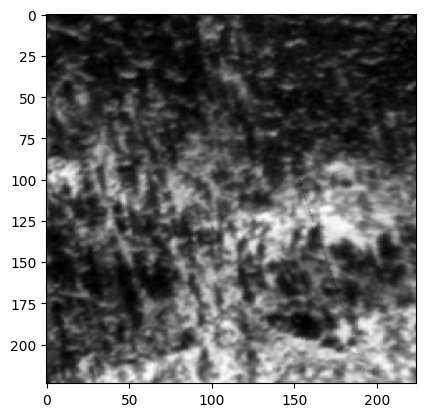

In [23]:
plt.imshow(img_reg[0], cmap='gray')

In [24]:
y = T.patch_images(img.unsqueeze(0), aercnn.patch_size)
#y = T.normalize_patches(y)
print(mae_loss(y, out, masks))

tensor(1.5702, grad_fn=<DivBackward0>)


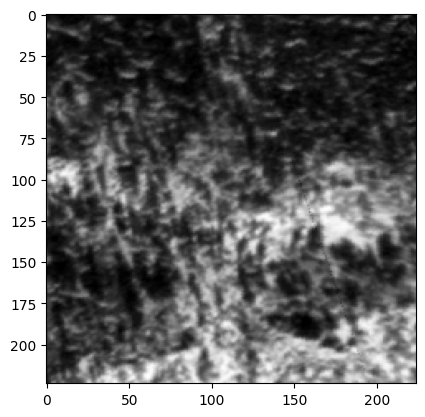

In [25]:
plt.imshow(T.unpatch_images(y).detach()[0], cmap='gray')

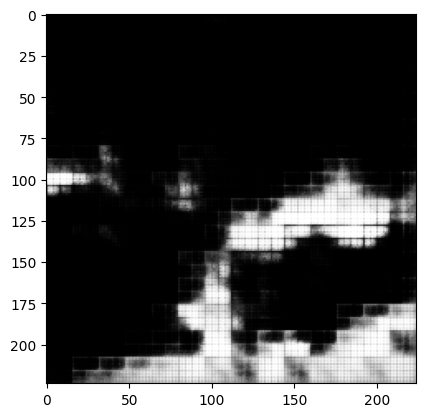

In [27]:
plt.imshow(T.unpatch_images(out).detach()[0], cmap='gray')

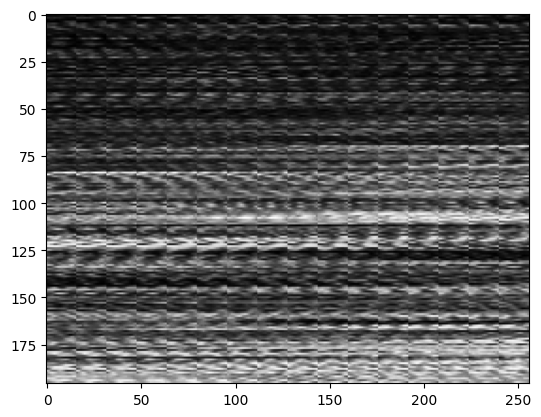

In [26]:
plt.imshow(y.detach()[0], cmap='gray')

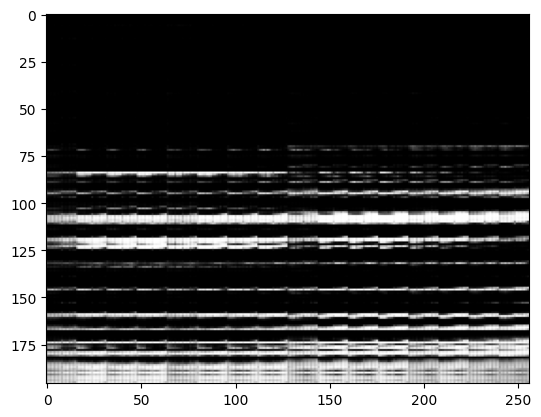

In [28]:
plt.imshow(out.detach()[0], cmap='gray')